In [2]:
import Pkg
Pkg.activate(".")

  Activating project at `~`


In [3]:
Pkg.add(["CairoMakie","LinearAlgebra","Distributions","Convex","SCS", "Statistics"])

   Resolving package versions...
  No Changes to `~/Project.toml`
  No Changes to `~/Manifest.toml`


In [4]:
using CairoMakie, LinearAlgebra, Statistics, Distributions, Convex, SCS

In [5]:
#Create the data
x = LinRange(0, 4, 100)
y_true = x .^ 2  # Parabola: y = x^2

100-element Vector{Float64}:
  0.0
  0.0016324864809713297
  0.006529945923885319
  0.014692378328741967
  0.026119783695541274
  0.040812162024283234
  0.05876951331496787
  0.07999183756759513
  0.1044791347821651
  0.1322314049586777
  0.16324864809713294
  0.19753086419753085
  0.23507805325987147
  ⋮
 12.641975308641975
 12.9309254157739
 13.223140495867767
 13.51862054892358
 13.817365574941332
 14.11937557392103
 14.424650545862667
 14.733190490766248
 15.044995408631774
 15.360065299459238
 15.67840016324865
 16.0

In [6]:
#Design matrix
col_list = Vector{Float64}[]
for p in 0:19
    push!(col_list, x .^ p)
end
A = reduce(hcat, col_list)

100×20 Matrix{Float64}:
 1.0  0.0         0.0          0.0          …  0.0          0.0
 1.0  0.040404    0.00163249   6.5959e-5       8.23467e-26  3.32714e-27
 1.0  0.0808081   0.00652995   0.000527672     2.15867e-20  1.74438e-21
 1.0  0.121212    0.0146924    0.00178089      3.19028e-17  3.86701e-18
 1.0  0.161616    0.0261198    0.00422138      5.65882e-15  9.14557e-16
 1.0  0.20202     0.0408122    0.00824488   …  3.14128e-13  6.34602e-14
 1.0  0.242424    0.0587695    0.0142472       8.36313e-12  2.02743e-12
 1.0  0.282828    0.0799918    0.022624        1.34095e-10  3.79257e-11
 1.0  0.323232    0.104479     0.033771        1.48343e-9   4.79491e-10
 1.0  0.363636    0.132231     0.0480841       1.23598e-8   4.49447e-9
 1.0  0.40404     0.163249     0.065959     …  8.23467e-8   3.32714e-8
 1.0  0.444444    0.197531     0.0877915       4.57841e-7   2.03485e-7
 1.0  0.484848    0.235078     0.113977        2.19234e-6   1.06295e-6
 ⋮                                          ⋱       

In [7]:
#Function to perform least squares
function fitlq(A, y)
    Ainv = pinv(A)
    return Ainv * y
end

fitlq (generic function with 1 method)

In [8]:
#Function to perform Lasso
function lasso(A, y, λ1, λ2)
    x = Variable(size(A)[2])
    problem = minimize(norm(A * x - y, 2) + λ1 * norm(x, 1) + λ2 * norm(x, 2))
    solve!(problem, SCS.Optimizer; silent = true)
    return vec(evaluate(x))
end

lasso (generic function with 1 method)

In [9]:
#Store coefficients for least squares and Lasso
n_trials = 100
b_ls = zeros(n_trials, 20)
b_lasso = zeros(n_trials, 20)

100×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [10]:
#Generate 100 realizations with noise
for i in 1:n_trials
    y_noisy = y_true .+ rand(Normal(0, 0.1), length(y_true))  # Add noise to y_true

    #Least Squares fit
    b_ls[i, :] = fitlq(A, y_noisy)

    #Lasso fit
    b_lasso[i, :] = lasso(A, y_noisy, 0.1, 0)
end

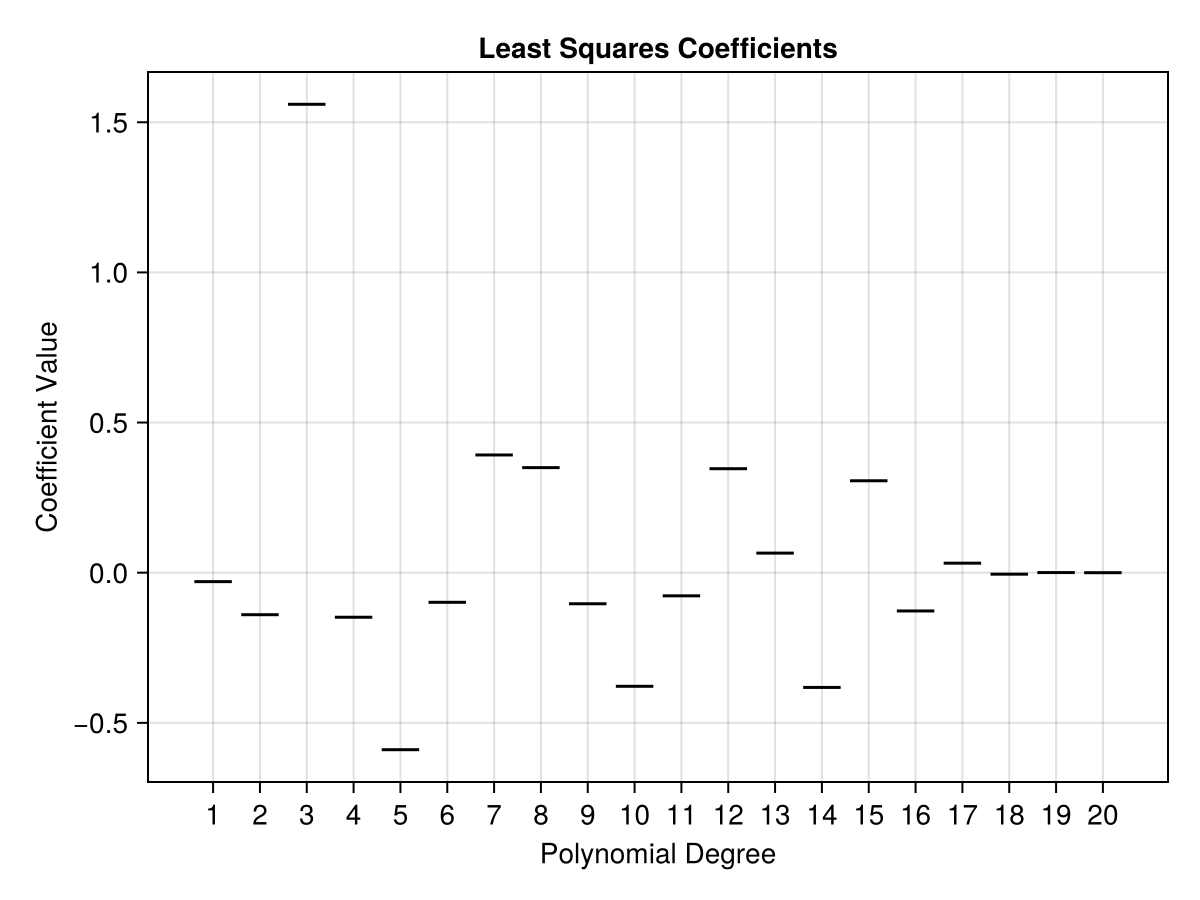

In [11]:
#Least Squares boxplot
function plot_least_squares(b_ls)
    fig1 = Figure() 
    ax1 = Axis(fig1[1, 1], title = "Least Squares Coefficients",
               ylabel = "Coefficient Value", xlabel = "Polynomial Degree", xticks = 1:20)
    boxplot!(ax1, 1:20, b_ls') 
    return fig1
end

fig1 = plot_least_squares(b_ls)

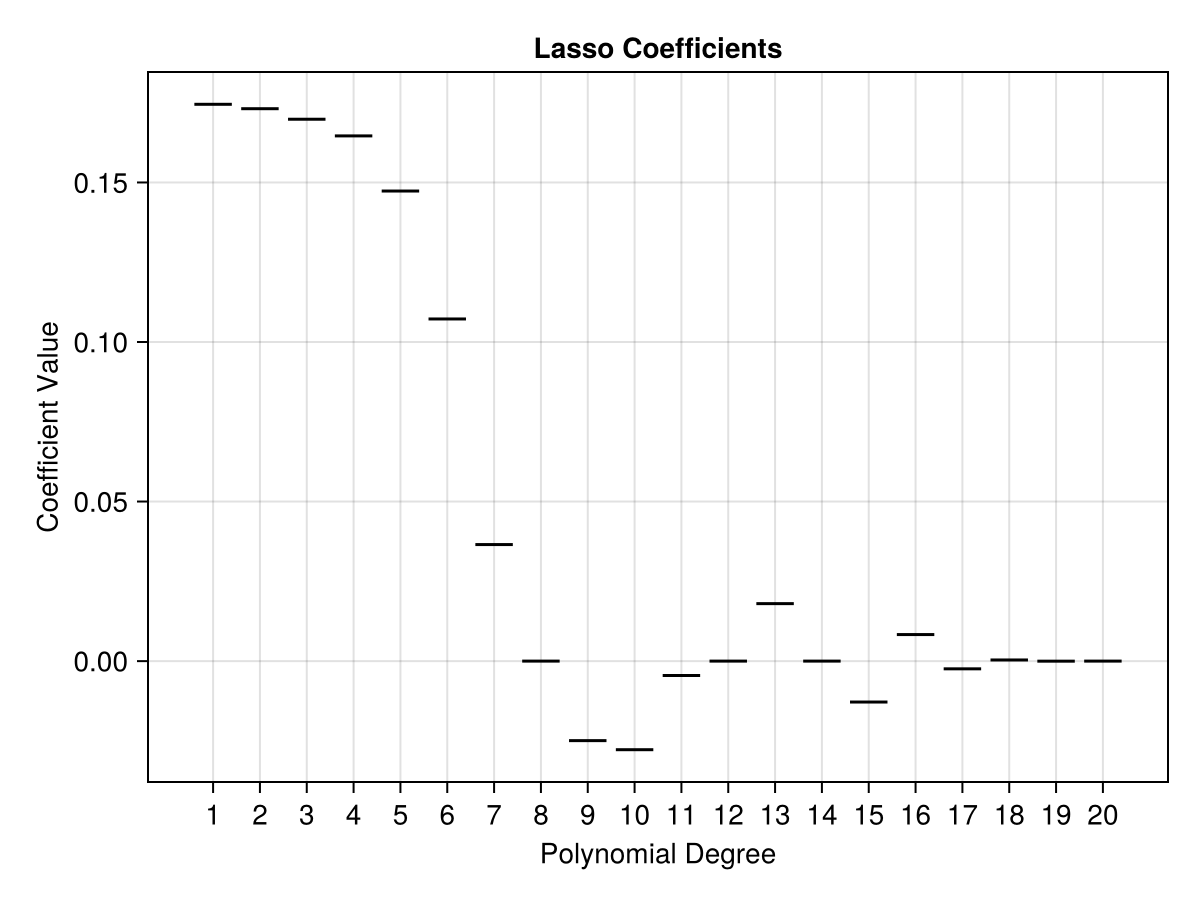

In [12]:
#Lasso boxplot
function plot_lasso(b_lasso)
    fig2 = Figure() 
    ax2 = Axis(fig2[1, 1], title = "Lasso Coefficients",
               ylabel = "Coefficient Value", xlabel = "Polynomial Degree", xticks = 1:20)
    boxplot!(ax2, 1:20, b_lasso') 
    return fig2
end

fig2 = plot_lasso(b_lasso)